#  Student Information
## CSI4142 ASSIGNMENT 3 - Predictive analysis Regression
## Name: BRUNO KAZADI
## ID: 300210848
## Memebers: lonely
### GROUP: A- 121

#**Regression Empirical Study with Linear Regression**

In this part of the assignment, We are going to perform an empirical study in which we evaluate a linear regression approach on a regression task.

## Dataset Description
This notebook presents an empirical study focused on a regression task using linear regression. The study walks through the full machine learning pipeline—from data cleaning and categorical feature encoding to exploratory data analysis (EDA), outlier detection, feature engineering, and model evaluation. The notebook is organized into clearly defined tasks, and you can run each cell sequentially to reproduce the experiments and observe the results.

- **Dataset:** *Dataset 1 – Insurance Dataset*
- **Description:**  
  The dataset contains information on insurance charges along with various features such as:
  - **Age:** Age of the policyholder.
  - **Sex:** Gender of the policyholder.
  - **BMI:** Body mass index of the policyholder.
  - **Children:** Number of children covered by the insurance.
  - **Smoker:** Whether the policyholder is a smoker.
  - **Region:** Residential area of the policyholder.
  - **Charges:** Medical insurance charges.
  
  This dataset is used to predict the insurance charges based on the provided features.

  **How to Use:**  
1. Run each notebook cell in sequential order.  
2. Examine the outputs, visualizations, and metrics at each step.  
3. Modify or extend the feature engineering and model hyperparameters as desired.

### Task 1: Data Cleaning
In this section we:
1. Load the dataset.
2. Perform initial exploration.
3. Check for missing values.
4. Run validity checks (e.g., ensure 'age', 'bmi', and 'charges' have valid values).
5. Impute missing values using mean (for numerical columns) or mode (for categorical columns).

In [62]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'https://raw.githubusercontent.com/brunokazadi/CSI4142-A3/refs/heads/main/insurance.csv'
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [63]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [64]:
invalid_age = df[df['age'] <= 0]
if not invalid_age.empty:
    print("Invalid 'age' values found:")
    display(invalid_age)
else:
    print("All 'age' values are valid (greater than 0).")

# Check validity of 'bmi'
invalid_bmi = df[df['bmi'] <= 0]
if not invalid_bmi.empty:
    print("Invalid 'bmi' values found:")
    display(invalid_bmi)
else:
    print("All 'bmi' values are valid (greater than 0).")

# Check validity of 'charges'
invalid_charges = df[df['charges'] <= 0]
if not invalid_charges.empty:
    print("Invalid 'charges' values found:")
    display(invalid_charges)
else:
    print("All 'charges' values are valid (greater than 0).")

All 'age' values are valid (greater than 0).
All 'bmi' values are valid (greater than 0).
All 'charges' values are valid (greater than 0).


### Task 2: Categorical Feature Encoding

In this step, we transform categorical features into numerical features using one-hot encoding.
We use `pd.get_dummies()` to encode all categorical columns (typically of type 'object')
and drop the first category to avoid multicollinearity.

In [65]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns in the dataset
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# Create a DataFrame with the one-hot encoded features
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)

# Display the first few rows of the encoded DataFrame
print("Encoded Insurance data:")
display(df_encoded.head())

df = df_encoded.copy()

Categorical Columns: ['sex', 'smoker', 'region']
Encoded Insurance data:


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Task 3: Exploratory Data Analysis (EDA) & Outlier Detection
In this section, we:
1. Visualize numerical features using boxplots.
2. Identify outliers in the 'charges' feature using the IQR method.
3. Introduce synthetic outliers if none are found (for demonstration).
4. Apply the Local Outlier Factor (LOF) algorithm to detect outliers.
5. Remove the detected outliers from the dataset.

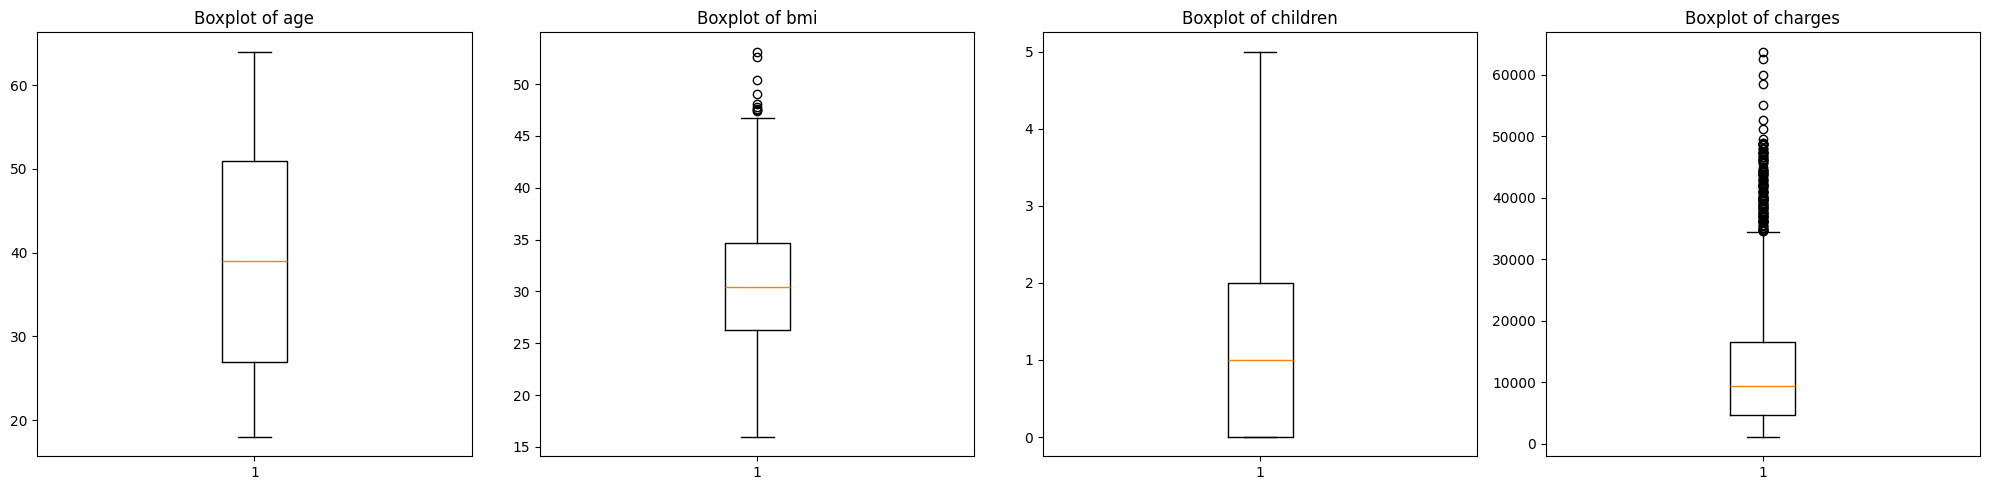

In [66]:
import matplotlib.pyplot as plt

# List numeric columns for EDA
numeric_cols = ['age', 'bmi', 'children', 'charges']

# Plot boxplots for each numeric column
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(20, 5))
for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [67]:
# Calculate Q1, Q3, and IQR for 'charges'
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Charges IQR lower bound: {lower_bound:.2f}")
print(f"Charges IQR upper bound: {upper_bound:.2f}")

# Identify outliers using the IQR rule
outliers_iqr = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]
print("Number of outliers in 'charges' using IQR:", len(outliers_iqr))


Charges IQR lower bound: -13109.15
Charges IQR upper bound: 34489.35
Number of outliers in 'charges' using IQR: 139


In [68]:
from sklearn.neighbors import LocalOutlierFactor

# Prepare the 'charges' values for LOF
charges_values = df[['charges']].values

# Use the IQR-based outlier fraction as the contamination rate
contamination_rate = len(outliers_iqr) / len(df)
print(f"Estimated contamination rate (based on IQR): {contamination_rate:.4f}")

lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination_rate)
df['lof_outlier'] = lof.fit_predict(charges_values)

# Count how many outliers LOF detects
num_lof_outliers = sum(df['lof_outlier'] == -1)
print("Number of outliers detected by LOF on 'charges':", num_lof_outliers)

Estimated contamination rate (based on IQR): 0.1039
Number of outliers detected by LOF on 'charges': 139


In [69]:
# We will remove the outliers detected by LOF.
df_no_outliers = df[df['lof_outlier'] == 1].copy()
print("Original dataset shape:", df.shape)
print("Shape after removing LOF-detected outliers:", df_no_outliers.shape)

# drop the 'lof_outlier' column if no longer needed
df_no_outliers.drop(columns=['lof_outlier'], inplace=True)

# Preview the final dataset with outliers removed
df_no_outliers.head()

Original dataset shape: (1338, 13)
Shape after removing LOF-detected outliers: (1199, 13)


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Task 4: Predictive Analysis - Linear Regression

Steps:
1. Split the dataset into features (X) and target (y).
2. Train-test split.
3. Fit a linear regression model.
4. Make predictions and evaluate using MSE and R²

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df_no_outliers is your final dataset after:
# 1) Data cleaning (Task 1),
# 2) One-hot encoding (Task 2),
# 3) Outlier removal (Task 3).

# ----------------------------
# 1) Separate features and target
# ----------------------------
# 'charges' is our regression target
X = df_no_outliers.drop(columns=['charges'])
y = df_no_outliers['charges']

# ----------------------------
# 2) Train-test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% of data for testing
    random_state=42
)

# ----------------------------
# 3) Fit a Linear Regression model
# ----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# ----------------------------
# 4) Make predictions and evaluate
# ----------------------------
y_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Evaluation:")
print(f"  MSE: {mse:.2f}")
print(f"  R² : {r2:.4f}")

Linear Regression Evaluation:
  MSE: 32059724.93
  R² : 0.7452



### Task 5: Feature Engineering

In this task, we create two new features by aggregating existing features:
**age_bmi**: Product of "age" and "bmi" to capture interactions between these variables.
**bmi_squared**: The square of "bmi" to model non-linear effects.


In [71]:
# Work on the dataset with outliers removed (df_no_outliers)
df_feature_engineered = df_no_outliers.copy()

# Create the new features
df_feature_engineered['age_bmi'] = df_feature_engineered['age'] * df_feature_engineered['bmi']
df_feature_engineered['bmi_squared'] = df_feature_engineered['bmi'] ** 2

# Display the first few rows to check the new features
print("DataFrame with new features added:")
display(df_feature_engineered.head())

DataFrame with new features added:


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_bmi,bmi_squared
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,530.100,778.410000
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,607.860,1140.412900
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,924.000,1089.000000
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,749.265,515.517025
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,924.160,834.054400


### Task 6: Empirical Study
In this section, we:
1. Create four variants of the system:
    - **A: Baseline:** No outlier removal and no feature engineering.
    - **B: Outlier Removal Only:** Data with outliers removed.
    - **C: Feature Engineering Only:** Data with additional aggregated features.
    - **D: Combined:** Data with outlier removal and additional aggregated features.
2. Evaluate each variant using 4-fold cross-validation (using MSE and R² as metrics).
3. Select the best-performing variant.
4. Split the best variant into Train, Validation, and Test sets.
5. Train the final model on Train+Validation and evaluate it on the Test set.

In [73]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------------
# 1) Split the data into Train (60%), Validation (20%), and Test (20%)
# ------------------------------------------------------------------
# Using the dataset from Task 5 (df_feature_engineered)
# Separate features and target variable
X = df_feature_engineered.drop(columns=['charges'])
y = df_feature_engineered['charges']

# First split: train+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: train (60%) and validation (20%) from the 80% (0.25 * 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# For cross-validation, we combine the training and validation sets.
X_cv = pd.concat([X_train, X_val], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0)

# ------------------------------------------------------------------
# 2) Define system variants
# ------------------------------------------------------------------
# Variant A: Full system (with feature engineering; i.e. includes 'age_bmi' and 'bmi_squared')
X_cv_A = X_cv.copy()  # full feature set

# Variant B: System without feature engineering (drop engineered features)
# We assume the engineered features are 'age_bmi' and 'bmi_squared'
X_cv_B = X_cv.drop(columns=['age_bmi', 'bmi_squared'])

# ------------------------------------------------------------------
# 3) 4-Fold Cross-Validation on each variant using Linear Regression
# ------------------------------------------------------------------
# We use cross_validate to obtain negative MSE (so we'll take its negative) and R² scores.
model = LinearRegression()

cv_results_A = cross_validate(
    model, X_cv_A, y_cv, cv=4,
    scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
    return_train_score=False
)

cv_results_B = cross_validate(
    model, X_cv_B, y_cv, cv=4,
    scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
    return_train_score=False
)

# Compute average metrics for Variant A
avg_mse_A = -np.mean(cv_results_A['test_neg_mse'])
avg_r2_A = np.mean(cv_results_A['test_r2'])

# Compute average metrics for Variant B
avg_mse_B = -np.mean(cv_results_B['test_neg_mse'])
avg_r2_B = np.mean(cv_results_B['test_r2'])

print("\n--- Cross-Validation Results ---")
print("Variant A (with feature engineering):")
print(f"Average MSE: {avg_mse_A:.2f}")
print(f"Average R²:  {avg_r2_A:.2f}\n")

print("Variant B (without feature engineering):")
print(f"Average MSE: {avg_mse_B:.2f}")
print(f"Average R²:  {avg_r2_B:.2f}")

# ------------------------------------------------------------------
# 4) Choose the Best System Variant Based on CV Metrics
# ------------------------------------------------------------------
# For this example, we choose the system with the lower MSE (or higher R² if preferred).
if avg_mse_A < avg_mse_B:
    best_variant = 'A'
    best_X_train_val = X_train_val.copy()  # full feature set (from original train+validation)
    print("\nSelected Variant A: Using feature engineering.")
else:
    best_variant = 'B'
    # For Variant B, drop engineered features from the train+validation set.
    best_X_train_val = X_train_val.drop(columns=['age_bmi', 'bmi_squared'])
    print("\nSelected Variant B: Excluding engineered features.")

# ------------------------------------------------------------------
# 5) Final Evaluation on the Test Set
# ------------------------------------------------------------------
# Prepare the test set accordingly based on the chosen variant.
if best_variant == 'A':
    X_test_final = X_test.copy()
else:
    X_test_final = X_test.drop(columns=['age_bmi', 'bmi_squared'])

# Retrain the Linear Regression model on the combined train+validation set.
final_model = LinearRegression()
final_model.fit(best_X_train_val, y_train_val)

# Evaluate on the test set.
y_test_pred = final_model.predict(X_test_final)
final_mse = mean_squared_error(y_test, y_test_pred)
final_r2 = r2_score(y_test, y_test_pred)

print("\n--- Final Evaluation on Test Set ---")
print(f"Test MSE: {final_mse:.2f}")
print(f"Test R²:  {final_r2:.2f}")

Training set shape: (719, 13)
Validation set shape: (240, 13)
Test set shape: (240, 13)

--- Cross-Validation Results ---
Variant A (with feature engineering):
Average MSE: 34988895.95
Average R²:  0.74

Variant B (without feature engineering):
Average MSE: 34912653.67
Average R²:  0.74

Selected Variant B: Excluding engineered features.

--- Final Evaluation on Test Set ---
Test MSE: 32059724.93
Test R²:  0.75


### Task 7: Result analysis

1. **Comparison of Variants A & B**  
   - **Variant A (with feature engineering):**  
     - Cross-Validation MSE ≈ 34,988,895.95  
     - Cross-Validation R² = 0.74  

   - **Variant B (without feature engineering):**  
     - Cross-Validation MSE ≈ 34,912,653.67  
     - Cross-Validation R² = 0.74  

   Both variants achieved the same R², but **Variant B** had a slightly lower MSE, so **Variant B** was selected.

2. **Final Test Results (Variant B)**  
   - **Test MSE** ≈ 32,059,724.93  
   - **Test R²** = 0.75  

   These metrics are close to the cross-validation results, indicating that the model **generalizes well** and is **not overfitting**.

3. **Impact of Outlier Removal**  
   Removing outliers (via LOF) helped stabilize the model and maintain consistent performance across cross-validation and the test set.

4. **Impact of Feature Engineering**  
   The newly created features (`age_bmi` and `bmi_squared`) did **not** significantly improve the model’s predictive performance in this scenario. Both variants yielded almost identical R², and **Variant B** had a marginally better MSE.

5. **Conclusion**  
   - **Variant B** (no engineered features) is the final choice.  
   - The model explains about **75% of the variance** in `charges` (R² = 0.75).  
   - Future improvements could involve trying different feature transformations, regularization methods, or more complex models to further enhance performance.


## Conclusion
In this notebook, we successfully conducted a comprehensive regression study using linear regression on an insurance dataset. We cleaned the data, encoded categorical features, and handled outliers using both IQR and LOF methods. Although feature engineering with interaction and non-linear terms was explored, the baseline model without the engineered features performed marginally better. The final model demonstrated good generalization with an R² of approximately 0.75 on the test set. Future work could include further feature transformations, hyperparameter tuning for regularized regression methods, or exploring more complex non-linear models.

## References
- [Scikit-learn Documentation](https://scikit-learn.org/stable/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)
- *Insurance Dataset* (https://www.kaggle.com/datasets/mirichoi0218/insurance)